In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
test = pd.read_csv('test_data_final.csv')

In [3]:
test.head(5)

,Unnamed: 0,event_timestamp,event_date,country,user_pseudo_id,event_name
0,0,1665273599626000,20221008,B,user_0,register_mobile
1,1,1665273599626000,20221008,B,user_0,register_mobile
2,2,1665273599556012,20221008,B,user_0,event1
3,3,1665273599556012,20221008,B,user_0,event1
4,4,1665273575218002,20221008,B,user_1,event2


In [4]:
test.shape

(780096, 6)

In [5]:
test.isnull().sum()

Unnamed: 0         0
event_timestamp    0
event_date         0
country            0
user_pseudo_id     0
event_name         0
dtype: int64

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780096 entries, 0 to 780095
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Unnamed: 0       780096 non-null  int64 
 1   event_timestamp  780096 non-null  int64 
 2   event_date       780096 non-null  int64 
 3   country          780096 non-null  object
 4   user_pseudo_id   780096 non-null  object
 5   event_name       780096 non-null  object
dtypes: int64(3), object(3)
memory usage: 35.7+ MB


In [3]:
#preprocessign data (unix time / date)

def time_transfer(x):
    df = datetime.fromtimestamp(x / 1_000_000)
    return df.replace(microsecond=0)
def date_transfer(x):
    a = pd.to_datetime(test['event_date'], format='%Y%m%d')
    return a

test["event_timestamp"]= test["event_timestamp"].apply(time_transfer)

test["event_date"]=pd.to_datetime(test['event_date'], format='%Y%m%d')

In [14]:
## Q1 Retention / Appear


def Q1_function (test):

    # filter event
    test['is_register_event'] = test['event_name'].isin(['register_mobile', 'register_email'])

    # the 0 day
    first_regist = test.groupby('user_pseudo_id')['event_date'].min().reset_index()
    first_regist.columns = ['user_pseudo_id', 'day_0']

    # Merge back original
    merge_orig = test.merge(first_regist, on='user_pseudo_id', how='left')

    # Calculate day 1
    merge_orig['day_1'] = merge_orig['day_0'] + pd.Timedelta(days=1)

    # Identify users in day1
    day_1_retention = merge_orig[(merge_orig['event_date'] == merge_orig['day_1'])]


    # Calculate retention rate
    total_users = first_regist.shape[0]
    retained_users = day_1_retention['user_pseudo_id'].nunique()
    retention_rate = (retained_users / total_users) * 100

    # anytime appear after day0
    appear = merge_orig[(merge_orig['event_date'] > merge_orig['day_0'])]
    appearance_rate = (appear['user_pseudo_id'].nunique() / total_users) * 100

    return f'retention_rate : {format(retention_rate, ".2f")}, appearance_rate : {format(appearance_rate, ".2f")}'




In [15]:
# Q1 Country A

test_A = test[test['country'].isin(['A'])].copy()
Q1_result_A = Q1_function(test_A)
print(Q1_result_A)

retention_rate : 15.59, appearance_rate : 23.60


In [16]:
# Q2 Country B
test_B = test[test['country'].isin(['B'])].copy()
Q1_result_B = Q1_function(test_B)
print(Q1_result_B)

retention_rate : 13.15, appearance_rate : 19.70


In [91]:
## Q2 specific event in firt event 5 min (Company A)

def Q2_function(test):
    # Identify first_open event for each user
    first_open = test.query("event_name == 'first_open'").groupby('user_pseudo_id')['event_timestamp'].min().reset_index()
    first_open.columns = ['user_pseudo_id', 'first_open_time']

    # Merge first_open time back to the main dataframe
    firt_merge = test.merge(first_open, on='user_pseudo_id', how='left')

    # Filter events that occurred within the first 5 minutes after first_open
    firt_merge['time_diff'] = (firt_merge['event_timestamp'] - firt_merge['first_open_time']).dt.total_seconds()
    event_5m = firt_merge.query("0 <= time_diff <= 300")

    # Identify day 1 for each user
    firt_merge['day_0'] = firt_merge.groupby('user_pseudo_id')['event_date'].transform('min')
    firt_merge['day_1'] = firt_merge['day_0'] + pd.Timedelta(days=1)

    # Calculate retention based on events within the first 5 minutes
    sig_events = event_5m['event_name'].unique()
    event_impact = {}

    for event in sig_events:
        users_with_event = event_5m.query("event_name == @event")['user_pseudo_id'].unique()
        day_1_retention = firt_merge.query("event_date == day_1 and user_pseudo_id in @users_with_event")['user_pseudo_id'].nunique()
        retention_rate = (day_1_retention / len(users_with_event))
        event_impact[event] = (retention_rate, len(users_with_event), day_1_retention)
        
    event_impact_sorted = sorted(event_impact.items(), key=lambda x: x[1], reverse=True)
    event_impact_sorted_tb = pd.DataFrame(event_impact_sorted, columns=['Event', 'Metrics'])
    event_impact_sorted_tb[['Retention Rate', 'Number of Users with Event', 'Day 1 Retention']] = pd.DataFrame(event_impact_sorted_tb['Metrics'].tolist(), index=event_impact_sorted_tb.index)
    event_impact_sorted_tb = event_impact_sorted_tb.drop(columns=['Metrics'])

    return event_impact_sorted_tb


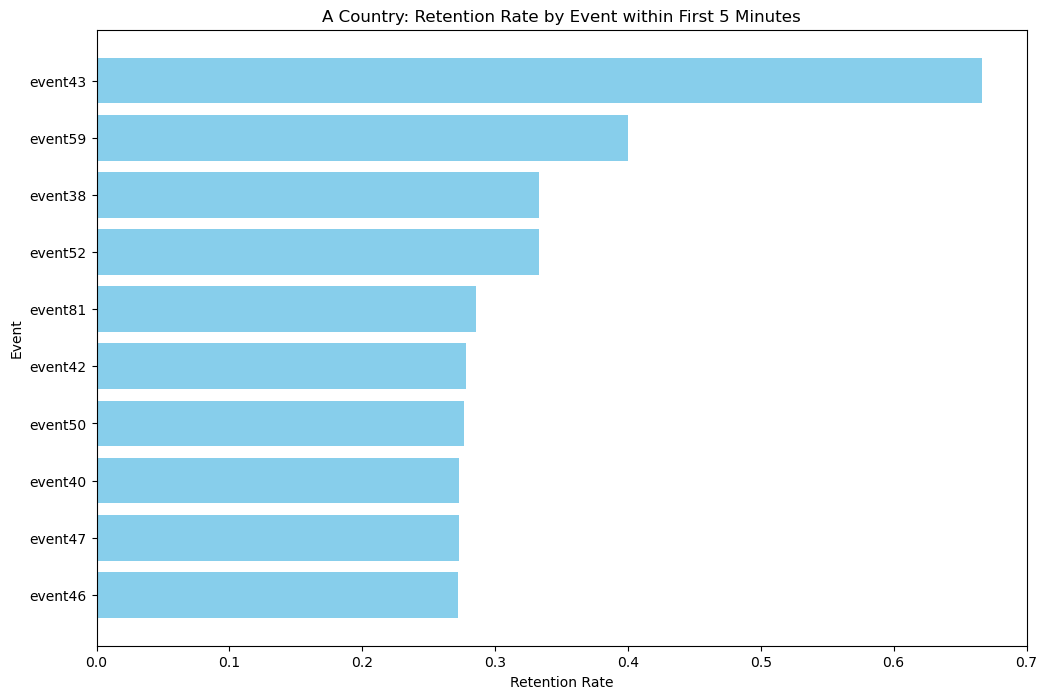

In [61]:
# Q2 plot
# Calculate event impact
event_impact_A = Q2_function(test_A)
event_impact_A = event_impact_A.head(10)

# Plot
plt.figure(figsize=(12, 8))
plt.barh(event_impact_A['Event'], event_impact_A['Retention Rate'], color='skyblue')
plt.xlabel('Retention Rate')
plt.ylabel('Event')
plt.title('A Country: Retention Rate by Event within First 5 Minutes')
plt.gca().invert_yaxis()
plt.show()

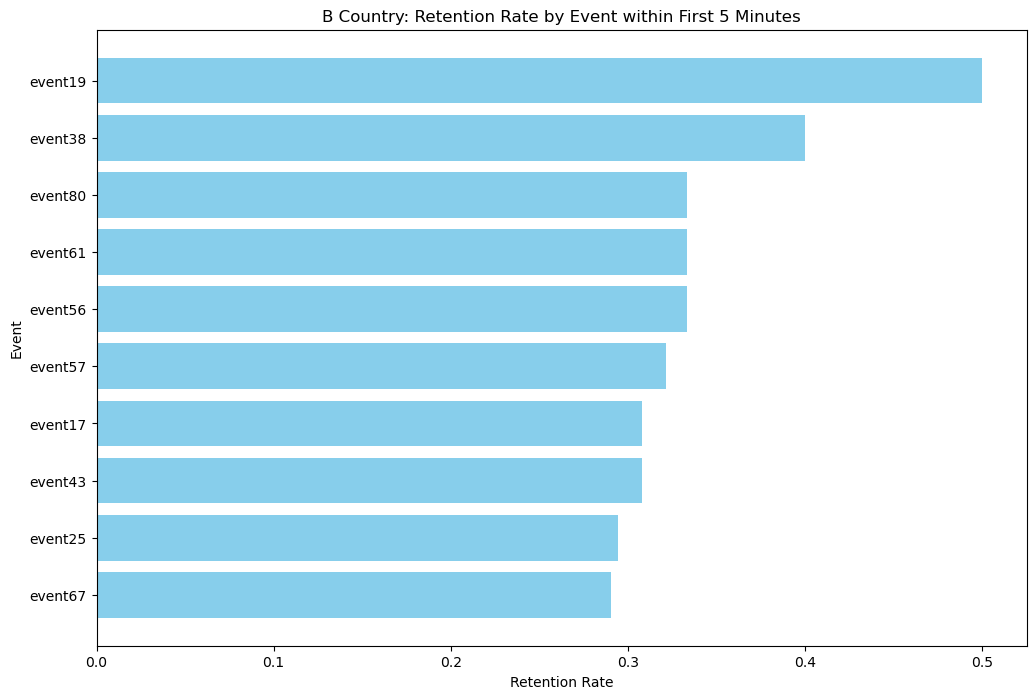

In [62]:
# Q2 plot
# Calculate retention and appearance rates
event_impact_B = Q2_function(test_B)
event_impact_B = event_impact_B.head(10)

# Plot
plt.figure(figsize=(12, 8))
plt.barh(event_impact_B['Event'], event_impact_B['Retention Rate'], color='skyblue')
plt.xlabel('Retention Rate')
plt.ylabel('Event')
plt.title('B Country: Retention Rate by Event within First 5 Minutes')
plt.gca().invert_yaxis()
plt.show()

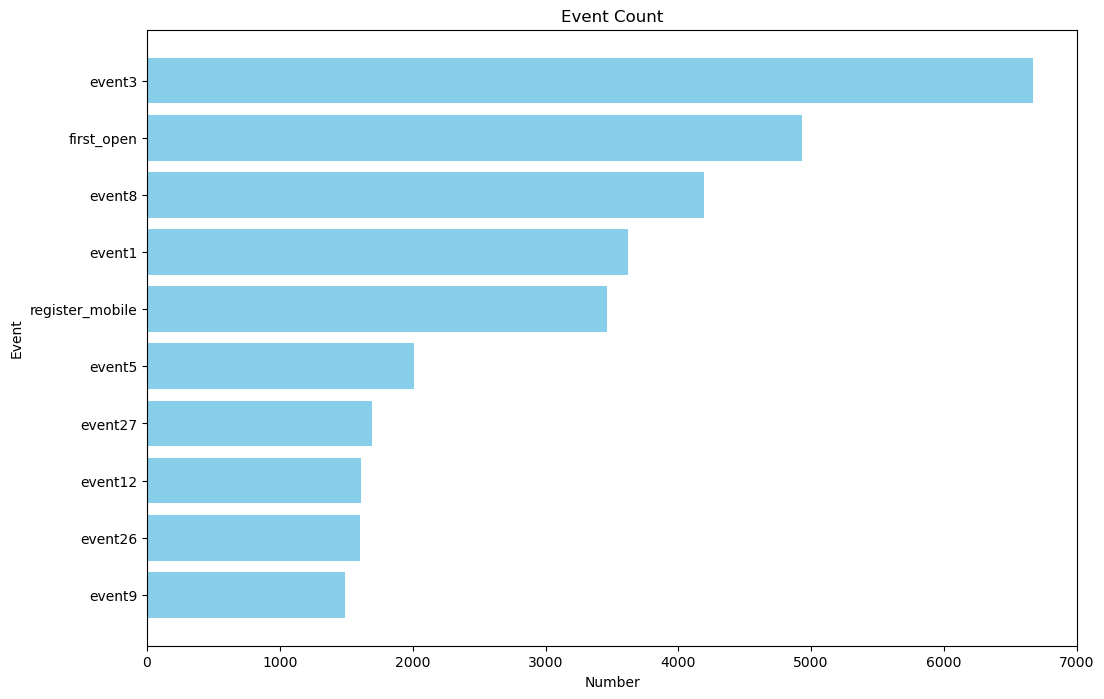

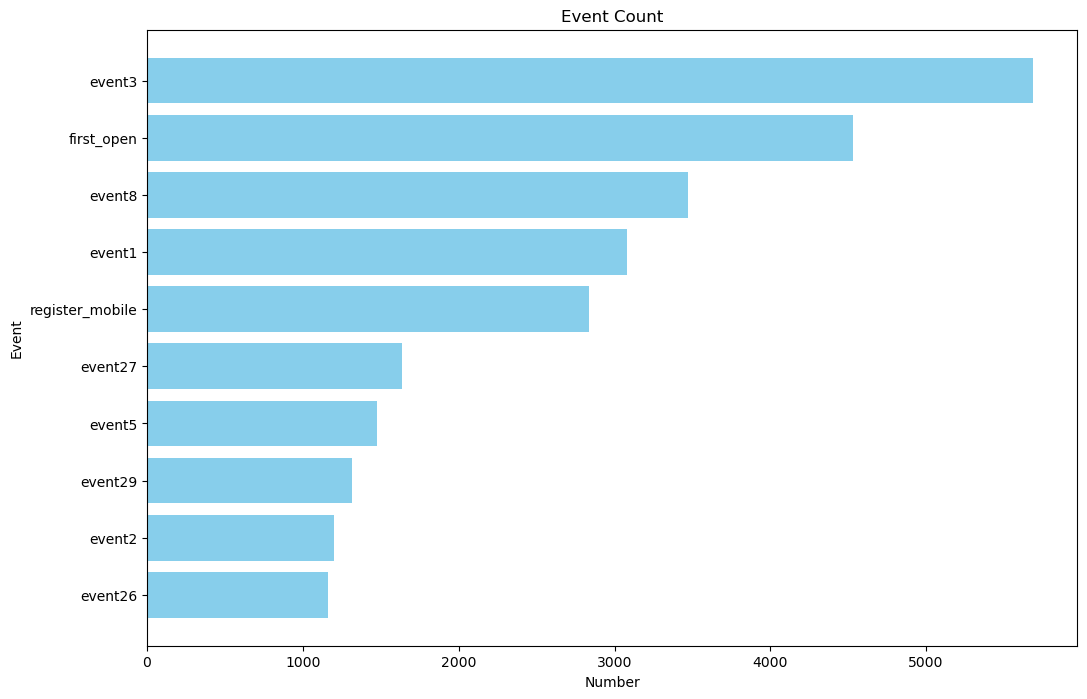

In [67]:
#Q3-1 event count

def event_count(test):
    # Count the number of unique user events per event name
    unique_events_by_name = test.drop_duplicates(subset=['event_date', 'user_pseudo_id', 'event_name'])

    # Count the number of events by event name
    event_totals = unique_events_by_name['event_name'].value_counts().reset_index()
    event_totals.columns = ['event_name', 'event_count']
    event_totals = event_totals.head(10)

    plt.figure(figsize=(12, 8))
    plt.barh(event_totals['event_name'], event_totals['event_count'], color='skyblue')
    plt.xlabel('Number')
    plt.ylabel('Event')
    plt.title('Event Count')
    plt.gca().invert_yaxis()
    plt.show()
    

event_count(test_A)
event_count(test_B)


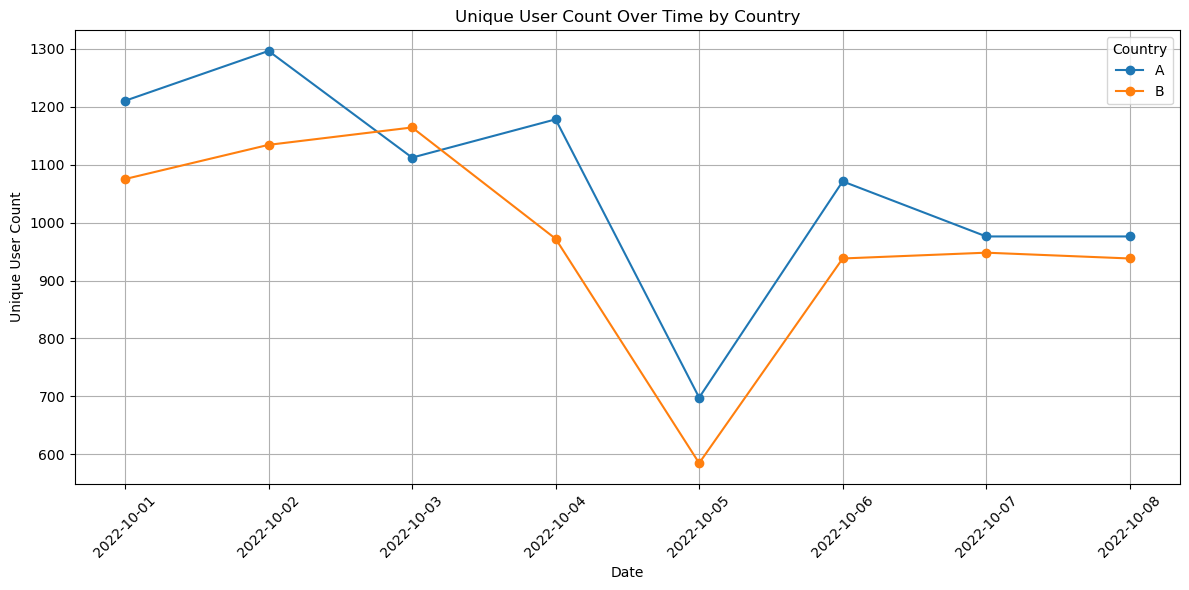

In [70]:
# Q3-2 user count over time


def user_count_time(test):
    # Group by event_date and country, then count unique users
    user_count_over_time = test.groupby(['event_date', 'country'])['user_pseudo_id'].nunique().reset_index()
    user_count_over_time.columns = ['event_date', 'country', 'unique_user_count']

    # Plot
    plt.figure(figsize=(12, 6))
    for country in user_count_over_time['country'].unique():
        country_data = user_count_over_time[user_count_over_time['country'] == country]
        plt.plot(country_data['event_date'], country_data['unique_user_count'], marker='o', label=country)
    
    plt.xlabel('Date')
    plt.ylabel('Unique User Count')
    plt.title('Unique User Count Over Time by Country')
    plt.legend(title='Country')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Call the function with the data
user_count_time(test)

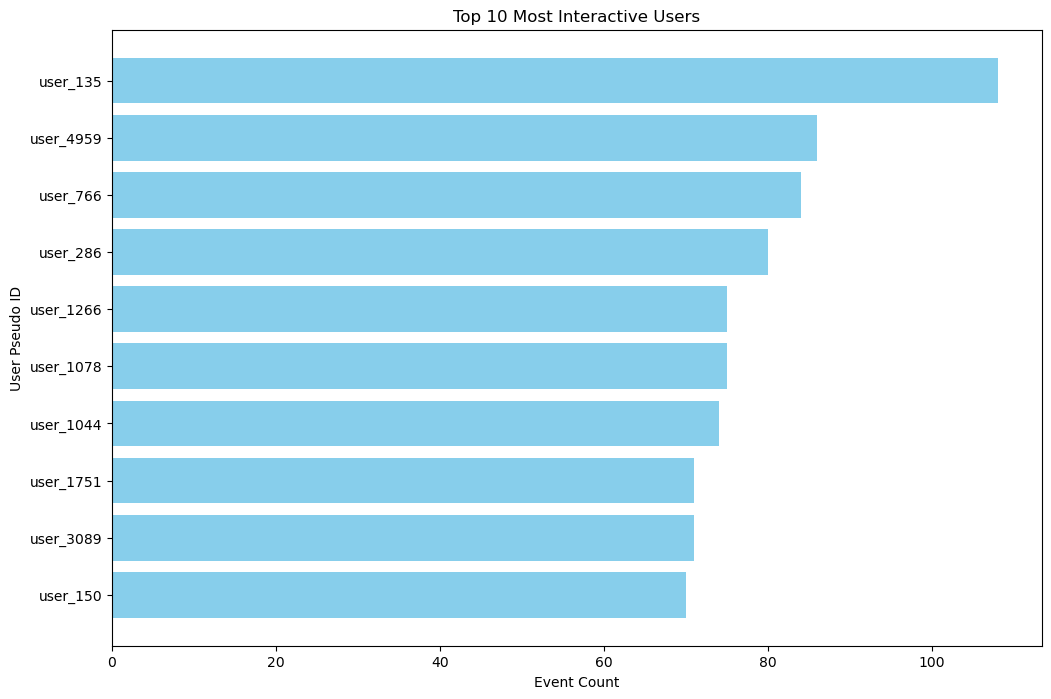

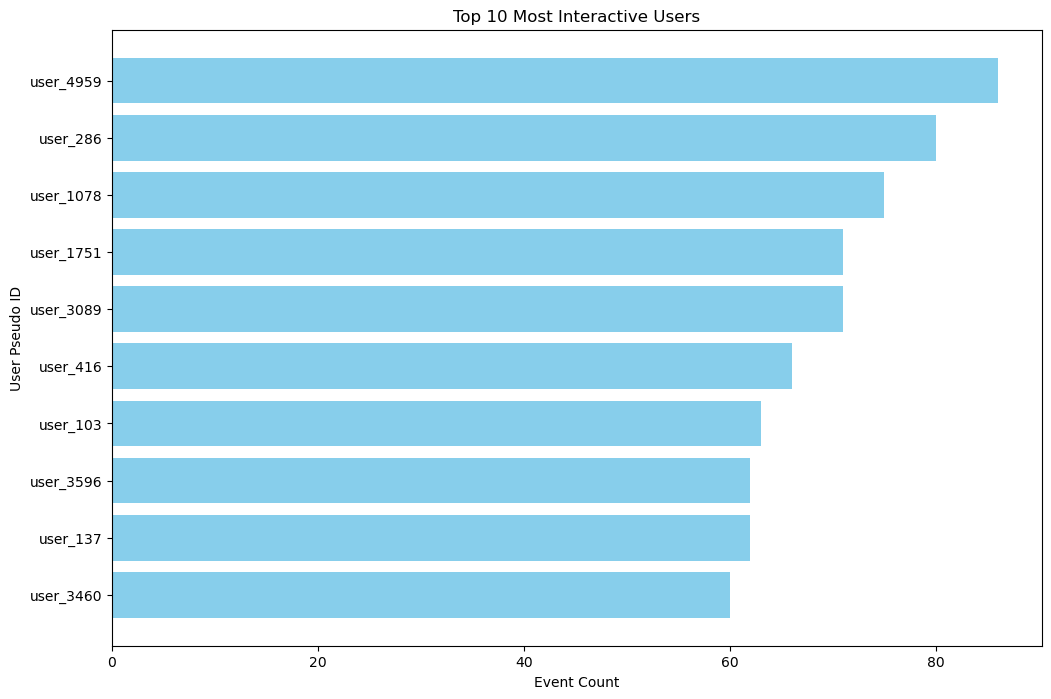

In [71]:
# event count by user
def count_event_user(test):
    # Count the number of events for each user on each day
    user_event_counts = test.groupby(['user_pseudo_id', 'event_date'])['event_name'].nunique().reset_index()
    user_event_counts.columns = ['user_pseudo_id', 'event_date', 'event_count']

    # Sum the event counts for each user
    total_event_counts = user_event_counts.groupby('user_pseudo_id')['event_count'].sum().reset_index()
    total_event_counts = total_event_counts.sort_values(by='event_count', ascending=False)

    # plot
    top_n = 10
    top_users = total_event_counts.head(top_n)

    plt.figure(figsize=(12, 8))
    plt.barh(top_users['user_pseudo_id'], top_users['event_count'], color='skyblue')
    plt.xlabel('Event Count')
    plt.ylabel('User Pseudo ID')
    plt.title(f'Top {top_n} Most Interactive Users')
    plt.gca().invert_yaxis()
    plt.show()
    
count_event_user(test)
count_event_user(test_B)

In [73]:
# Q3-3 avg-user-event
def avg_count_event(test):
    # Count the number of events for each user on each day
    user_event_counts = test.groupby(['user_pseudo_id', 'event_date'])['event_name'].nunique().reset_index()
    user_event_counts.columns = ['user_pseudo_id', 'event_date', 'event_count']

    # Sum the event counts for each user
    total_event_counts = user_event_counts.groupby('user_pseudo_id')['event_count'].sum().reset_index()
    total_event_counts = total_event_counts.sort_values(by='event_count', ascending=False)
    avg_user_event = total_event_counts.describe()
    return print(avg_user_event)

avg_count_event(test_A)
avg_count_event(test_B)

       event_count
count  6249.000000
mean      9.032005
std       8.333897
min       1.000000
25%       3.000000
50%       7.000000
75%      12.000000
max     108.000000
       event_count
count  5924.000000
mean      7.709318
std       7.726843
min       1.000000
25%       2.000000
50%       6.000000
75%      10.000000
max      86.000000


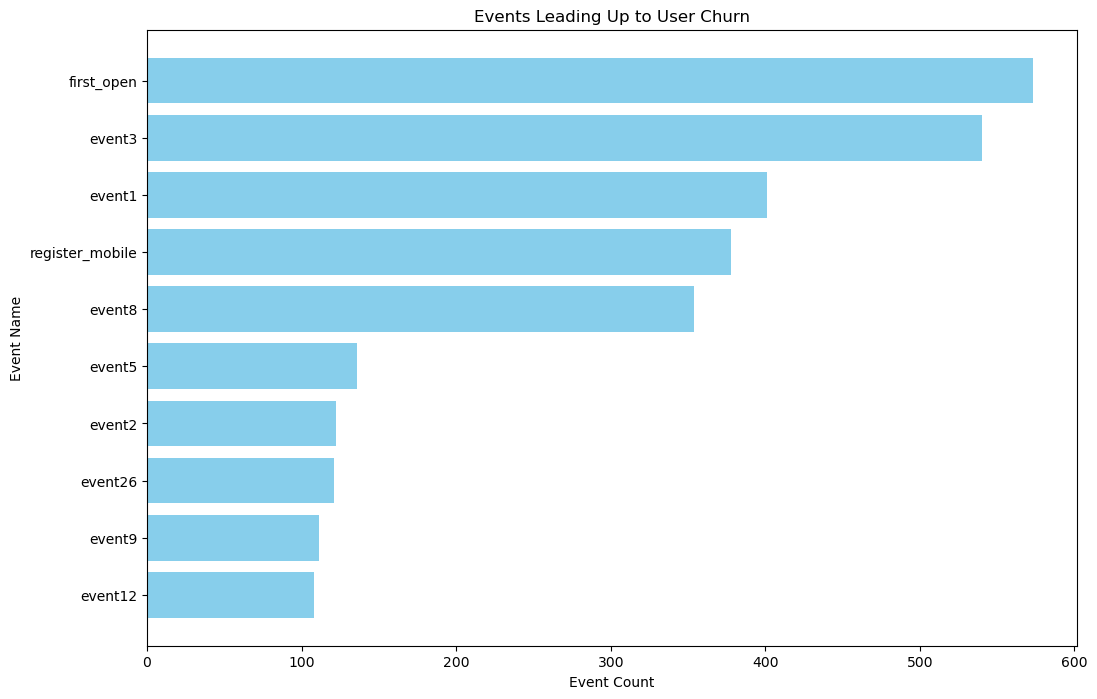

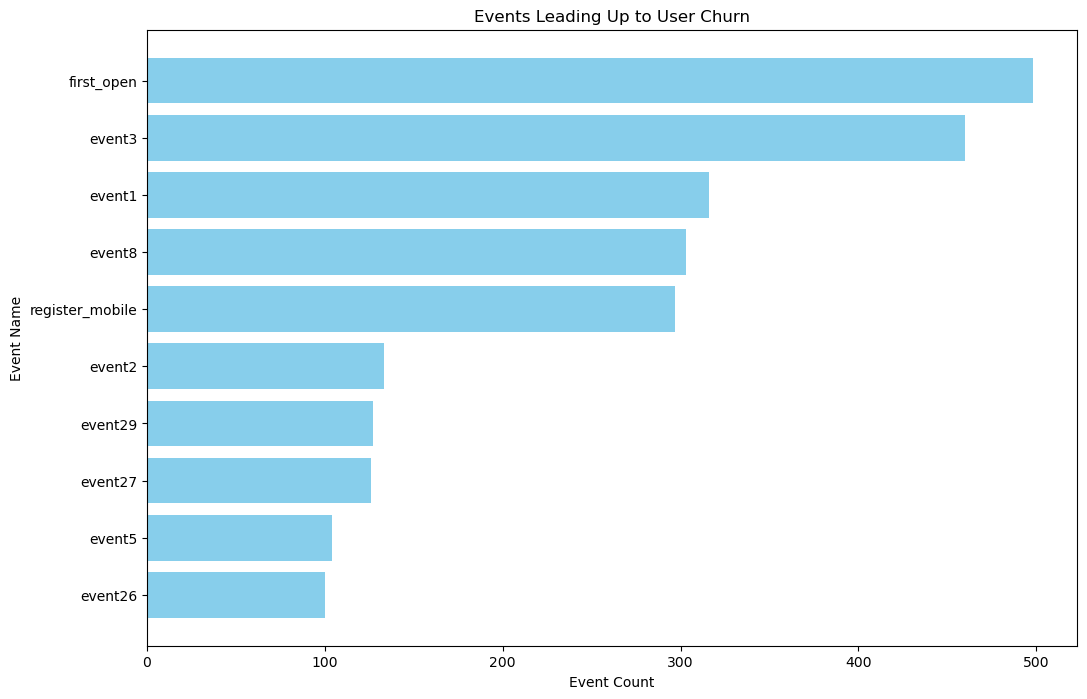

In [75]:
# Q3-4 Churn analysis (to event by 7 days)
def churn_analysis(test):
    # churn criteria:
    churn_threshold_days = 7

    # last event date for each user
    user_last_event = test.groupby('user_pseudo_id')['event_date'].max().reset_index()
    user_last_event.columns = ['user_pseudo_id', 'last_event_date']

    # overall last date in the dataset
    overall_last_date = test['event_date'].max()

    # churned users
    user_last_event['days_since_last_event'] = (overall_last_date - user_last_event['last_event_date']).dt.days
    churned_users = user_last_event[user_last_event['days_since_last_event'] >= churn_threshold_days]['user_pseudo_id']

    # Filter churned users
    churned_data = test[test['user_pseudo_id'].isin(churned_users)]

    # events leading up to churn
    event_counts = churned_data.groupby('event_name')['user_pseudo_id'].nunique().reset_index()
    event_counts.columns = ['event_name', 'user_count']
    event_counts = event_counts.sort_values(by='user_count', ascending=False).head(10)

    # plot
    plt.figure(figsize=(12, 8))
    plt.barh(event_counts['event_name'], event_counts['user_count'], color='skyblue')
    plt.xlabel('Event Count')
    plt.ylabel('Event Name')
    plt.title('Events Leading Up to User Churn')
    plt.gca().invert_yaxis()
    plt.show()
    
churn_analysis(test_A)
churn_analysis(test_B)


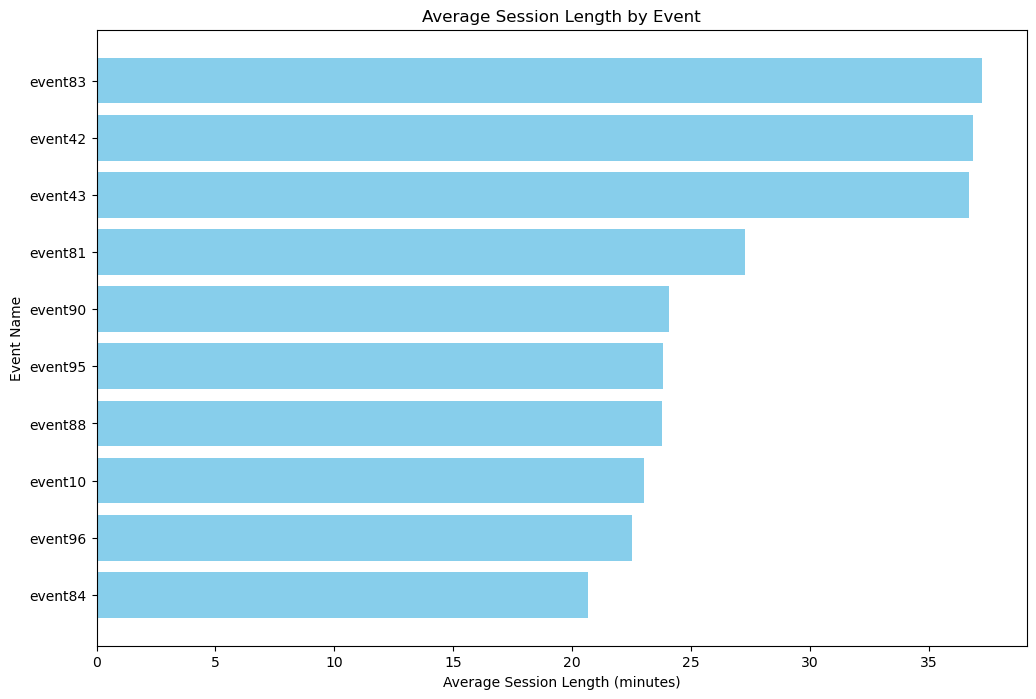

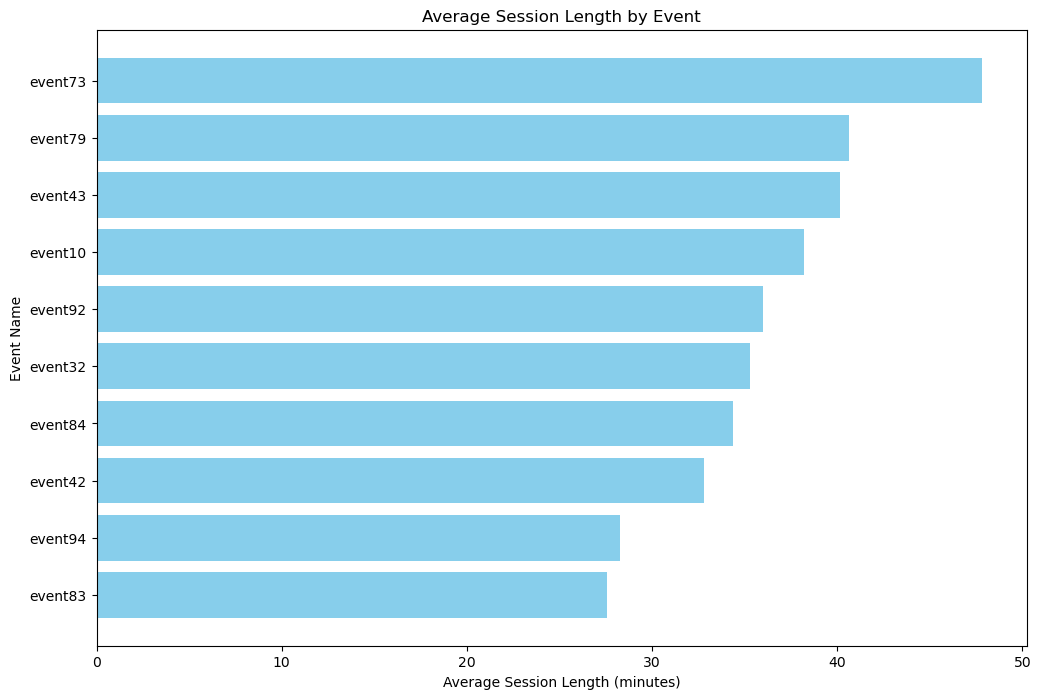

In [17]:
# Q3-5 session length to event
def session_length(test):
    # event to session length
    session_gap = pd.Timedelta(minutes=10)

    # Sessions check
    test = test.sort_values(by=['user_pseudo_id', 'event_timestamp'])
    test['prev_timestamp'] = test.groupby('user_pseudo_id')['event_timestamp'].shift(1)
    test['session_start'] = (test['event_timestamp'] - test['prev_timestamp']) > session_gap
    test['session_id'] = test.groupby('user_pseudo_id')['session_start'].cumsum()

    # Calculate session lengths
    session_lengths = test.groupby(['user_pseudo_id', 'session_id']).agg(
        session_start=('event_timestamp', 'min'),
        session_end=('event_timestamp', 'max')
    ).reset_index()
    session_lengths['session_length'] = (session_lengths['session_end'] - session_lengths['session_start']).dt.total_seconds() / 60  # Convert to minutes

    # Merge back to the original data
    test = test.merge(session_lengths[['user_pseudo_id', 'session_id', 'session_length']], on=['user_pseudo_id', 'session_id'])

    # Calculate average session length by event
    event_session_length = test.groupby('event_name')['session_length'].mean().reset_index()
    event_session_length = event_session_length.sort_values(by='session_length', ascending=False)
    event_session_length = event_session_length.head(10)
    # Plot
    plt.figure(figsize=(12, 8))
    plt.barh(event_session_length['event_name'], event_session_length['session_length'], color='skyblue')
    plt.xlabel('Average Session Length (minutes)')
    plt.ylabel('Event Name')
    plt.title('Average Session Length by Event')
    plt.gca().invert_yaxis()
    plt.show()
    
session_length(test_A)
session_length(test_B)